In [93]:
import numpy as np
import pandas as pd
import re
import itertools # check
import operator # check

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
sns.set() # Plot style
#sns.set_style('whitegrid')

import IPython
from IPython.display import display
IPython.core.pylabtools.figsize(12, 4)

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
#from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score

# Import models
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import Perceptron
from sklearn.linear_model import SGDClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier


from __future__ import division

# Auxiliary functions

In [31]:
# Function to create submission
def create_submission_from_list(Y_pred, filename):
    submission = pd.DataFrame({
        "PassengerId": df_test["PassengerId"],
        "Survived": Y_pred   
    })  
 
    submission.to_csv(filename, index=False)
    
    return Y_pred

## Score related functions

In [32]:
def compute_model_score_and_pred(model, X_train, Y_train, X_test):
    """
    Score a particular model
        
    Returns:
    Scores for each classifier, and the prediction given for each one
    """
    model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    score = model.score(X_train,Y_train)
    return score, Y_pred

def compute_model_score_cv_and_pred(model, X_train, Y_train, X_test):
    """
    Score a particular model using k-fold cross validation
    
    Returns:
    Scores for each classifier, and the prediction given for each one
    """
    fit = model.fit(X_train,Y_train)
    Y_pred = model.predict(X_test)
    x_val = cross_val_score(fit, X_train, Y_train, cv =5, scoring='accuracy')
    return np.mean(x_val), Y_pred

# Build a table with scores for different models
model_list = [{'function': LogisticRegression(), 'name': 'LR'},
              {'function': SVC(), 'name': 'SVC'},
              {'function': KNeighborsClassifier(n_neighbors = 3), 'name': 'KN-3'},
              {'function': DecisionTreeClassifier(), 'name': 'DT'},
              {'function': GaussianNB(), 'name': 'GNB'},
              {'function': Perceptron(), 'name': 'Perceptron'},
              {'function': SGDClassifier(), 'name': 'SGD'},
              {'function': RandomForestClassifier(n_estimators=100), 'name': 'Random Forest'},
              {'function': XGBClassifier(), 'name': 'XGBoost'}
             ]

def get_scores(model_list, X_train, Y_train, X_test):
    """
    Iterates over different models to get their respective scores and predictions
    
    Returns:
    List of [model_name, score, score_cv, Y_predition]
    """
    model_results = []
    for model in model_list:
        score, Y_pred = compute_model_score(model['function'], X_train, Y_train, X_test)
        score_cv, Y_pred = compute_model_score_cv(model['function'], X_train, Y_train, X_test)
        model_results.append([model['name'], score, score_cv, Y_pred])    
    
    # Print scores
    df_model_results = pd.DataFrame (model_results, columns=columns)  
    df_sorted = df_model_results.sort_values(by='Score-CV', ascending=False)
    display(df_sorted)
    
    return model_results

def print_scores(model_results, columns=('Model', 'Score', 'Score-CV', 'Prediction')):
    """Show the results sorted by score"""
    df_model_results = pd.DataFrame (model_results, columns=columns)  
    df_sorted = df_model_results.sort_values(by='Score-CV', ascending=False)
    display(df_sorted)
    
    return df_model_results

## Confusion matrix functions
Functions in following cell are taken from https://www.kaggle.com/vinceallenvince/titanic-guided-by-a-confusion-matrix

In [79]:
# Function taken from http://notmatthancock.github.io/2015/10/28/confusion-matrix.html
def show_confusion_matrix(C,class_labels=['0','1']):
    """
    C: ndarray, shape (2,2) as given by scikit-learn confusion_matrix function
    class_labels: list of strings, default simply labels 0 and 1.

    Draws confusion matrix with associated metrics.
    """
    import matplotlib.pyplot as plt
    import numpy as np
    
    assert C.shape == (2,2), "Confusion matrix should be from binary classification only."
    
    # true negative, false positive, etc...
    tn = C[0,0]; fp = C[0,1]; fn = C[1,0]; tp = C[1,1];

    NP = fn+tp # Num positive examples
    NN = tn+fp # Num negative examples
    N  = NP+NN

    fig = plt.figure(figsize=(8,8))
    ax  = fig.add_subplot(111)
    ax.imshow(C, interpolation='nearest', cmap=plt.cm.gray)

    # Draw the grid boxes
    ax.set_xlim(-0.5,2.5)
    ax.set_ylim(2.5,-0.5)
    ax.plot([-0.5,2.5],[0.5,0.5], '-k', lw=2)
    ax.plot([-0.5,2.5],[1.5,1.5], '-k', lw=2)
    ax.plot([0.5,0.5],[-0.5,2.5], '-k', lw=2)
    ax.plot([1.5,1.5],[-0.5,2.5], '-k', lw=2)

    # Set xlabels
    ax.set_xlabel('Predicted Label', fontsize=16)
    ax.set_xticks([0,1,2])
    ax.set_xticklabels(class_labels + [''])
    ax.xaxis.set_label_position('top')
    ax.xaxis.tick_top()
    # These coordinate might require some tinkering. Ditto for y, below.
    ax.xaxis.set_label_coords(0.34,1.06)

    # Set ylabels
    ax.set_ylabel('True Label', fontsize=16, rotation=90)
    ax.set_yticklabels(class_labels + [''],rotation=90)
    ax.set_yticks([0,1,2])
    ax.yaxis.set_label_coords(-0.09,0.65)


    # Fill in initial metrics: tp, tn, etc...
    ax.text(0,0,
            'True Neg: %d\n(Num Neg: %d)'%(tn,NN),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,1,
            'False Neg: %d'%fn,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,0,
            'False Pos: %d'%fp,
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    ax.text(1,1,
            'True Pos: %d\n(Num Pos: %d)'%(tp,NP),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    # Fill in secondary metrics: accuracy, true pos rate, etc...
    ax.text(2,0,
            'False Pos Rate: %.2f'%(fp / (fp+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,1,
            'True Pos Rate: %.2f'%(tp / (tp+fn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(2,2,
            'Accuracy: %.2f'%((tp+tn+0.)/N),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(0,2,
            'Neg Pre Val: %.2f'%(1-fn/(fn+tn+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))

    ax.text(1,2,
            'Pos Pred Val: %.2f'%(tp/(tp+fp+0.)),
            va='center',
            ha='center',
            bbox=dict(fc='w',boxstyle='round,pad=1'))


    plt.tight_layout()
    plt.show()

In [89]:
confusion_scores = []
def get_confusion_scores(model, X, y):
    """
    Returns relevant confusion matrix scores.
    """
    
    # accuracy: fraction of the classifier's predictions that are correct.
    accuracy = cross_val_score(model, X, y, cv=5, scoring='accuracy')

    # precision: fraction of correct positive predictions.
    # A precision score of one indicates the classifier did not make any false positive predictions.
    precision = cross_val_score(model, X, y, cv=5, scoring='precision')

    # recall: fraction of truly positive instances the classifier recognizes.
    # A recall score of one indicates the classifier did not make any false negative predictions.
    recall = cross_val_score(model, X, y, cv=5, scoring='recall')

    # F1: harmonic mean bw precision and recall
    f1 = cross_val_score(model, X, y, cv=5, scoring='f1')
    
    return {'accuracy': np.mean(accuracy),
            'precision': np.mean(precision),
            'recall': np.mean(recall),
            'f1': np.mean(f1)}

In [90]:
def check_classifiers(X_train, Y_train):
    """
    Returns a sorted list of accuracy scores from fitting and scoring passed data
    against several alogrithms.
    """
    _cv = 5
    classifier_score = {}
    
    scores = cross_val_score(LogisticRegression(), X, y, cv=_cv)
    classifier_score['LogisticRegression'] = scores.mean()
    
    scores = cross_val_score(KNeighborsClassifier(), X, y, cv=_cv)
    classifier_score['KNeighborsClassifier'] = scores.mean()
    
    scores = cross_val_score(RandomForestClassifier(), X, y, cv=_cv)
    classifier_score['RandomForestClassifier'] = scores.mean()
    
    scores = cross_val_score(SVC(), X, y, cv=_cv)
    classifier_score['SVC'] = scores.mean()
    
    scores = cross_val_score(GaussianNB(), X, y, cv=_cv)
    classifier_score['GaussianNB'] = scores.mean()

    return sorted(classifier_score.items(), key=operator.itemgetter(1), reverse=True)



# Reading the data

In [34]:
# Open CSV file for train data and test data
df = []
df.append(pd.read_csv('data/train.csv'))
df.append(pd.read_csv('data/test.csv'))

# Create two different pointers to the train and the test data
df_train = df[0]
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [35]:
df_test = df[1]
df_test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


# Filling the nulls + Feature Engineering
* Check if there are NaN values in certain columns, such as Embarked, and replace them by other values
* Data imputation is done in both train and test datasets, but only taking information from the train dataset. This way we avoid to include information from the test dataset into the train one. We may get higher accuracy by also exploring the test dataset, but this is not a good practice
* We will create new features for data imputation, so we can always go back and apply different transformations

## Name
* The variable 'name' contains not only the firstname and surname of the passenger, but also the title. We may extract something useful if we process this feature. Title may be related to social status, which might have an effect on the survival opportunities in the Titanic.
* Title could help us to impute better ages.
* All names in the dataset have the format 'Surname, Title. Name (aka name)

In [36]:
# Parse the feature to extract all titles
def get_title(name):
    if '.' in name:
        return name.split(',')[1].split('.')[0].strip()
    else:
        return 'unknown'

list_title = df_train['Name'].apply(lambda x: get_title(x))
print list_title.value_counts()
#list_title = df_test['Name'].apply(lambda x: get_title(x))
#print list_title.value_counts()
#df_train[df_train['Name'].str.contains('Master')]

Mr              517
Miss            182
Mrs             125
Master           40
Dr                7
Rev               6
Mlle              2
Col               2
Major             2
Lady              1
Jonkheer          1
Don               1
Ms                1
Mme               1
Capt              1
the Countess      1
Sir               1
Name: Name, dtype: int64


After having a look on the title, we can notice that there are a few titles that can be merged:
* There are not enough occurrences of certain titles. It would be better to create a category for those that seem to belong to cabin crew members
* 'Mme' is 'Madame', the French equivalent to Ms. We will transform this title to Miss
* 'Mlle' is 'Mademoiselle', the French equivalent to Miss.
* 'Col'->Colonel. 'Capt'->Captain. 'Major'
* 'Lady' is a noble title, or the wife of a Lord, Baron or Sir.
* 'Jonkheer' is Dutch honorific of nobility.
* 'Master' is used for male young and unmarried children.
* 'Don' is a Spanish noble title. We will merge all noble titles to one value: 'noble'.
* 'Rev' is Reverend. Merge it with another title? Think about Dr as well. They could belong to the cabin crew
* We will assume that 'Dr' only refers to medical doctors, who could be part of the cabin crew.

There might be more honorific titles that are not present in the train data, but in the test data or the score data. It is not possible to take into account all possible titles. 

In [37]:
# Create a new feature with the title of each person

# Map of titles
Title_Dictionary = {
    "Mr" :        "Mr",
    "Miss" :      "Miss",
    "Mlle":       "Miss",
    "Mme":        "Miss",
    "Ms":         "Miss",
    "Mrs" :       "Mrs",
    "Master" :    "Master",
    "Dr":         "Crew",
    "Rev":        "Crew",
    "Capt":       "Crew",
    "Col":        "Crew",
    "Major":      "Crew",
    "Jonkheer":   "Noble",
    "Don":        "Noble",
    "Dona":       "Noble",
    "Sir" :       "Noble",
    "Lady" :      "Noble",
    "the Countess":"Noble"
}

df_train['Title'] = df_train['Name'].apply(lambda x: get_title(x))
df_train['Title'] = df_train['Title'].map(Title_Dictionary)

df_test['Title'] = df_test['Name'].apply(lambda x: get_title(x))
df_test['Title'] = df_test['Title'].map(Title_Dictionary)

## Embarked
* Replace NaN in embarked by 'S', by far the most repeated value.

In [38]:
df_train['EmbarkedFill'] = df_train['Embarked'].fillna('S')
print 'Embarked nulls in train: ' + str(df_train['Embarked'].isnull().sum())

df_test['EmbarkedFill'] = df_test['Embarked'].fillna('S')
print 'Embarked nulls in test: ' + str(df_test['Embarked'].isnull().sum())

Embarked nulls in train: 2
Embarked nulls in test: 0


## Age
* Replace NaN by median depending on the class, sex, and title
* Play with the fact that 'Woman and Child first!'?
    * Created another variables for child (<16) 

In [39]:
# How many nulls we have in age?
print 'Age nulls in train: ' + str(df_train['Age'].isnull().sum())
print 'Age nulls in test: ' + str(df_test['Age'].isnull().sum())

# Calculate the median per class
df_train['AgeFill'] = df_train['Age']
df_test['AgeFill'] = df_test['Age']

age_median_table = df_train.groupby(['Sex','Pclass','Title'])['Age'].median()
print age_median_table

def fill_age_sex_class(x,base_table):
    age = base_table.loc[x['Sex'], x['Pclass'], x['Title']]                 
    return age

df_train['AgeFill'] = df_train.apply(lambda x: fill_age_sex_class(x,age_median_table) if np.isnan(x['AgeFill']) else x['AgeFill'], axis=1)
df_test['AgeFill'] = df_test.apply(lambda x: fill_age_sex_class(x,age_median_table) if np.isnan(x['AgeFill']) else x['AgeFill'], axis=1)

Age nulls in train: 177
Age nulls in test: 86
Sex     Pclass  Title 
female  1       Crew      49.0
                Miss      29.5
                Mrs       41.5
                Noble     40.5
        2       Miss      24.0
                Mrs       32.0
        3       Miss      18.0
                Mrs       31.0
male    1       Crew      51.0
                Master     4.0
                Mr        40.0
                Noble     40.0
        2       Crew      46.5
                Master     1.0
                Mr        31.0
        3       Master     4.0
                Mr        26.0
Name: Age, dtype: float64


In [40]:
def person(passenger):
    """Returns man, woman, or child"""
    age, sex = passenger
    if age < 16:
        return "child"
    else:
        return dict(male="man", female="woman")[sex]

# Create 5 intervals for age
#pd.cut(df_train['Age'], 5)

# Create a new colum    
df_train['Person'] = df_train[['Age','Sex']].apply(person, axis=1)
df_test['Person'] = df_test[['Age','Sex']].apply(person, axis=1)

[(0, 1.1)]

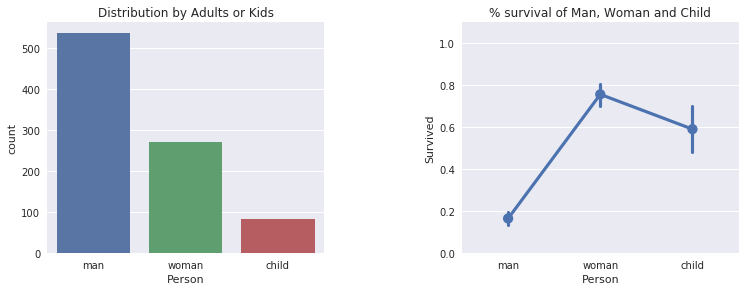

In [41]:
# Survived by Adults and kids (and sex)
#fig_survived_by_age = sns.pointplot('Age', 'Survived', data=df_train)
fig, axs = plt.subplots(ncols=2)
plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.5, hspace=0.2)
fig_person = sns.countplot('Person', data=df_train, ax=axs[0])
fig_survived_by_person = sns.pointplot('Person', 'Survived', data=df_train, ax=axs[1])

fig_person.set_title('Distribution by Adults or Kids')
fig_survived_by_person.set_title('% survival of Man, Woman and Child')
fig_survived_by_person.set(ylim=(0, 1.1))

Survival ratio seems to be quiet biased againts men. Women and children seems to had better chance of survival

## Fare
* Replace NaN by mean depending on the sex, class, and embarkation point

In [42]:
# How many nulls we have in age?
print 'Fare nulls in train: ' + str(df_train['Fare'].isnull().sum())
print 'Fare nulls in test: ' + str(df_test['Fare'].isnull().sum())

Fare nulls in train: 0
Fare nulls in test: 1


In [43]:
df_train['FareFill'] = df_train['Fare']
df_test['FareFill'] = df_test['Fare']

fare_median_table = df_train.groupby(['Sex', 'Embarked','Pclass'])['Fare'].median()
print fare_median_table

def fill_fare_sex_embarked_class(x,base_table):
    fare = base_table.loc[x['Sex'], x['Embarked'], x['Pclass']]           
    return fare

#df_train['FareFill'] = df_train.apply(lambda x: fill_fare_sex_embarked_class(x,fare_median_table) if np.isnan(x['FareFill']) else x['FareFill'], axis=1)
df_test['FareFill'] = df_test.apply(lambda x: fill_fare_sex_embarked_class(x,fare_median_table) if np.isnan(x['FareFill']) else x['FareFill'], axis=1)

Sex     Embarked  Pclass
female  C         1         83.1583
                  2         24.0000
                  3         14.4583
        Q         1         90.0000
                  2         12.3500
                  3          7.7500
        S         1         79.6500
                  2         23.0000
                  3         14.4500
male    C         1         61.6792
                  2         25.8604
                  3          7.2292
        Q         1         90.0000
                  2         12.3500
                  3          7.7500
        S         1         35.0000
                  2         13.0000
                  3          8.0500
Name: Fare, dtype: float64


## Ticket
* Ticket seems a difficult variable to process, but there are no nulls in both train and test dataset, and we should be able to extract something meaningful from it
* Tickets are either a number, or a alphanumeric prefix + number. This prefix could contain extra info, such as location at the Titanic (deck)
* There seems to be a repetition on the ticket number. This may mean people 'travelling together', which could be useful together with FamilyID to cover those cases of extra people travelling with the Family (nannies, servants, etc.) that could have a stronger chance of survival.

In [44]:
# How many nulls we have in ticket?
print('Ticket nulls in Train=%d and Test=%d'
      % (df_train['Ticket'].isnull().sum() , df_test['Ticket'].isnull().sum()))

Ticket nulls in Train=0 and Test=0


In [45]:
#df_train['Ticket'].describe(include='all')
#print df_train['Ticket'].value_counts().head(3)

# How many different prefix do we have?
def getTicketPrefix(ticket):   
    prefix = ticket.split()[0].replace('.','').replace('/','')
    if prefix.isdigit():
        return 'U'
    else:
        return prefix
    
def getTicketNumber(ticket):
    ticket_number_pattern = re.compile("([0-9]+$)")
    match = ticket_number_pattern.search(ticket)
    if match:
        return match.group()
    else:
        return 0 # Unknown
    
# Create multiple features with ticket. We can later discard as many as we want
df_train['TicketPrefix'] = df_train['Ticket'].apply(lambda x: getTicketPrefix(x.upper()))
df_train['TicketNumber'] = df_train['Ticket'].apply(lambda x: getTicketNumber(x.upper()))
df_train['TicketFirstDigit'] = df_train['TicketNumber'].apply(lambda x: str(x)[0]).astype(np.int)
df_train['TicketNumDigits'] = df_train['TicketNumber'].apply(lambda x: len(str(x))).astype(np.int)

#display(df_train)
#display(df_train['TicketPrefix'].value_counts())

df_test['TicketPrefix'] = df_test['Ticket'].apply(lambda x: getTicketPrefix(x.upper()))
df_test['TicketNumber'] = df_test['Ticket'].apply(lambda x: getTicketNumber(x.upper()))
df_test['TicketFirstDigit'] = df_test['TicketNumber'].apply(lambda x: str(x)[0]).astype(np.int)
df_test['TicketNumDigits'] = df_test['TicketNumber'].apply(lambda x: len(str(x))).astype(np.int)

# Process ticket creating same categories for train and test. Otherwise, we will be getting different columns
train_categories = df_train['TicketPrefix'].astype('category').cat.categories.tolist()
test_categories = df_test['TicketPrefix'].astype('category').cat.categories.tolist()
ticket_categories = list(set().union(train_categories,test_categories))

print 'Ticket categories: '
print ticket_categories
# Set TicketPrefix feature as categorical, using the previous list
df_train['TicketPrefix'] = df_train['TicketPrefix'].astype('category', categories=ticket_categories)
df_test['TicketPrefix'] = df_test['TicketPrefix'].astype('category', categories=ticket_categories)

Ticket categories: 
['SCAH', 'WC', 'STONO', 'FCC', 'SOPP', 'FA', 'FC', 'LINE', 'SWPP', 'PP', 'SOP', 'SOTONOQ', 'STONOQ', 'PC', 'PPP', 'A5', 'A4', 'LP', 'SCPARIS', 'A', 'AQ4', 'C', 'AQ3', 'SOTONO2', 'CA', 'SOC', 'AS', 'STONO2', 'U', 'SP', 'SCOW', 'WEP', 'CASOTON', 'SC', 'SCA3', 'SCA4']


## 5.6.  'SibSp' and 'Parch'
* SibSp (Number of Siblings/Spouses Aboard) and Parch (Number of Parents/Children Aboard) could be merged into one feature: 'FamilySize'
* Create variable 'Alone' (or without family), as derivate of SibSp and Parch

In [46]:
# Create 'FamilySize' feature
df_train['FamilySize'] = df_train['SibSp'] + df_train['Parch'] + 1 
df_test['FamilySize'] = df_test['SibSp'] + df_test['Parch'] + 1 

# Create boolean 'Alone' feature
df_train['Alone'] = df_train.apply(lambda x: 1 if (x['FamilySize']==1) 
                                   else 0, axis=1)
df_test['Alone'] = df_test.apply(lambda x: 1 if (x['FamilySize']==1) 
                                   else 0, axis=1)

# Prediction models

## Null hyphotesis
We can guess that everyone died in the Titanic. 

In [122]:
null_hypothesis = 1 - df_train['Survived'].mean()
null_hypothesis

0.6161616161616161

In [113]:
# Build 
df_train['null_hypo'] = 0.0
X = pd.DataFrame(df_train['null_hypo'])
y = df_train['Survived']

In [114]:
# In order to get the confusion matrix, 
# split the training data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)
class_names = ['Dead','Survived']

In [115]:
clf = SVC()
y_pred = clf.fit(X_train, y_train).predict(X_test)

In [116]:
scores = check_classifiers(X, y)
print scores

[('RandomForestClassifier', 0.61616490890978648), ('LogisticRegression', 0.61616490890978648), ('SVC', 0.61616490890978648), ('GaussianNB', 0.61616490890978648), ('KNeighborsClassifier', 0.57035485304386468)]


In [111]:
scores = check_classifiers(X, y)
print scores

[('RandomForestClassifier', 0.61616490890978648), ('LogisticRegression', 0.61616490890978648), ('SVC', 0.61616490890978648), ('GaussianNB', 0.61616490890978648), ('KNeighborsClassifier', 0.57035485304386468)]


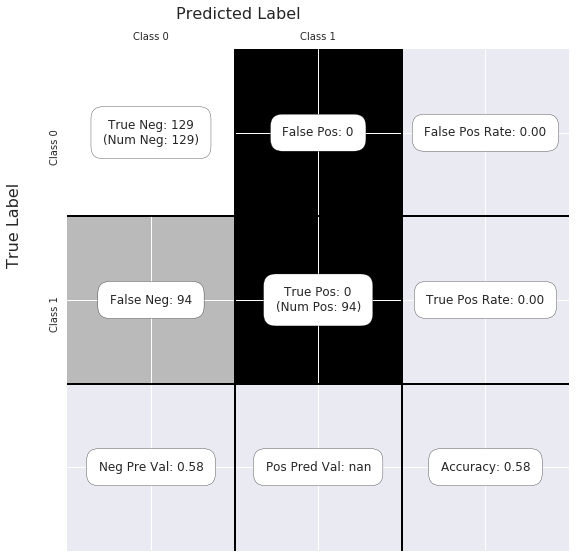

In [117]:
C = confusion_matrix(y_test, y_pred)
show_confusion_matrix(C, ['Class 0', 'Class 1'])

## 

In [52]:
# Create a clean data frame for the regression

# Columns to keep
cols_to_keep = ['AgeFill', 'SibSp', 'Parch', 'FareFill', 'FamilySize', 'Alone']
#cols_to_keep = ['AgeFill', 'SibSp', 'Parch', 'FareFill', 'FamilySize', 'Alone', 'TicketFirstDigit', 'TicketNumDigits']
##cols_to_drop = ['TicketPrefix', 'TicketNumber', 'TicketFirstDigit', 'TicketNumDigits']

# Replace categorical variables by dummy variables
#cols_dummy = ['Sex', 'Embarked', 'Pclass', 'Title']
cols_dummy = ['Sex', 'Embarked', 'Pclass', 'Title', 'Person']
#cols_dummy = ['Sex', 'Embarked', 'Pclass', 'Title', 'Person', 'TicketPrefix'] # Worse accuracy

In [119]:
# Training set
X_train = df_train[cols_to_keep].join(
    pd.get_dummies(df_train[cols_dummy], prefix=cols_dummy, columns=cols_dummy))

# Target
Y_train = df_train['Survived']

# Test set
X_test = df_test[cols_to_keep].join(
    pd.get_dummies(df_test[cols_dummy], prefix=cols_dummy, columns=cols_dummy))

# Scale features
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)

In [120]:
model_results = get_scores(model_list, X_train, Y_train, X_test)
df_model_results = print_scores(model_results)

,Model,Score,Score-CV,Prediction
8,XGBoost,0.876543,0.832821,"[0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
0,LR,0.835017,0.827209,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
7,Random Forest,0.984287,0.802502,"[0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ..."
4,GNB,0.805836,0.800249,"[0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, ..."
3,DT,0.984287,0.793456,"[0, 1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ..."
2,KN-3,0.849607,0.747521,"[0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, ..."
1,SVC,0.881033,0.741953,"[0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, ..."
5,Perceptron,0.730640,0.679036,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ..."
6,SGD,0.762065,0.637040,"[0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, ..."
